# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [1]:
%%bash
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Couldn't find program: 'bash'


In [3]:
# !python -m pip uninstall gym --yes

In [5]:
# !pip install gym[classic_control]==0.21.0
# !pip install pyglet==1.5.27

state vector dim = 4
n_actions = 2


C:\Users\user\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Изменение режима для потока после его установки невозможно
  warnings.warn(str(err))


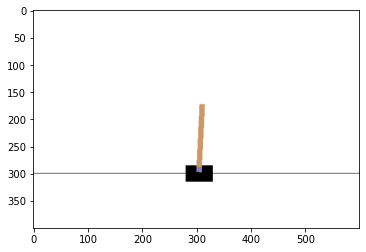

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [4]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [5]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba(s.reshape(1,-1)).reshape(-1) # predictions of actions
        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(range(2),size=1,p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(int(a))

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    return states, actions, total_reward

In [6]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.02448905  0.01654552  0.01047699 -0.02793688]
 [-0.02415814 -0.17872511  0.00991825  0.26803315]
 [-0.02773265 -0.3739872   0.01527892  0.5638278 ]
 [-0.03521239 -0.17908292  0.02655547  0.27599734]
 [-0.03879405 -0.37457347  0.03207542  0.5769362 ]]
actions: [array([0]), array([0]), array([1]), array([0]), array([0])]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    r_pr = np.percentile(rewards_batch,percentile)
    
    elite_states, elite_actions = [],[]
    
    for i, r in enumerate(rewards_batch):
        if r >= r_pr:
            elite_actions.extend(actions_batch[i])
            elite_states.extend(states_batch[i])
            
#     elite_states, elite_actions = states_batch[inds], actions_batch[inds]
#     print(elite_states.shape)
    
    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [8]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 700.000, threshold=700.000


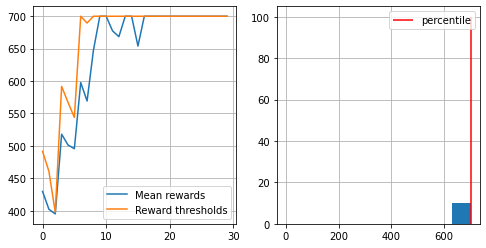

100%|██████████| 30/30 [00:37<00:00,  1.24s/it]

You Win! You may stop training now via KeyboardInterrupt.


In [10]:
import tqdm 
n_sessions = 10
percentile = 70
log = []

for i in tqdm.trange(30):
    # generate new sessions
    sessions = [generate_session(env, agent, t_max=700) for i in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

    agent.fit(elite_states, elite_actions)


    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 150:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [17]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

In [19]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
import sys

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Homework (1 pt max)

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __1__ (0.4 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2__ (up to 0.6 pts) Devise a way to speed up training against the default version
  * (0.2 pts) Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling.
  * (0.2 pts)Try re-using samples from 3-5 last iterations when computing threshold and training.
  * (0.2 pts) Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2`. Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

state vector dim = 2
n_actions = 3


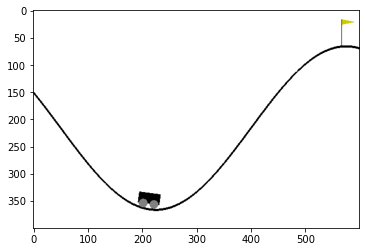

In [49]:
env = gym.make("MountainCar-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

In [64]:
from IPython.display import clear_output
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [65]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    r_pr = np.percentile(rewards_batch,percentile)
    
    elite_states, elite_actions = [],[]
    
    for i, r in enumerate(rewards_batch):
        if r > r_pr:
            elite_actions.extend(actions_batch[i])
            elite_states.extend(states_batch[i])
            
#     elite_states, elite_actions = states_batch[inds], actions_batch[inds]
#     print(elite_states.shape)
    
    return elite_states, elite_actions

In [97]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()
#     print(env.action_space.n)
    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba(s.reshape(1,-1)).reshape(-1) # predictions of actions
        if len(probs)<3:
            new_probs = np.zeros(3)
            new_probs[0] = probs[0]
            new_probs[2] = probs[1]
            probs = new_probs
            print("hey")
        
        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(range(env.action_space.n),size=1,p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(int(a))

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    return states, actions, total_reward

# baseline -150


# Also there is an addition of joblib and histoty of sessions implemented in class memory_states

In [66]:
from collections import deque

class memory_states:
    """
    Class provides saving sessions. 
    """
    def __init__(self,number_pred_it=3):
        self.n_it = number_pred_it
        self.states = []
        self.actions = []
        self.rewards = []
        
        self.deq = deque()
    def update(self,states_batch, actions_batch, rewards_batch):
        
        self.states.extend(states_batch)
        self.actions.extend(actions_batch)
        self.rewards.extend(rewards_batch)
        
        self.deq.append(len(actions_batch))
        if len(self.deq) >= self.n_it:
            ind = self.deq.popleft()
            self.states, self.actions, self.rewards = self.states[ind:], self.actions[ind:], self.rewards[ind:]
            
        return self.states, self.actions, self.rewards
            
        
        
        
        
        
        
        
    

In [98]:
from sklearn.neural_network import MLPClassifier

agent_simple = MLPClassifier(
    hidden_layer_sizes=(20,20),
    activation='relu',
)

agent_simple.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(hidden_layer_sizes=(20, 20))

mean reward = -143.472, threshold=-110.000


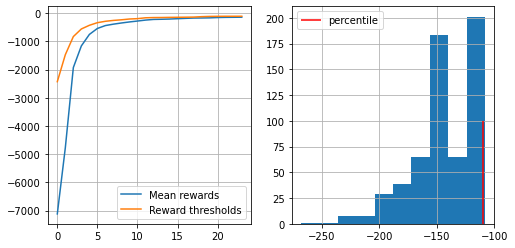

 23%|██▎       | 23/100 [02:08<07:10,  5.59s/it]

You Win! You may stop training now via KeyboardInterrupt.


In [102]:
import tqdm
from joblib import Parallel, delayed
n_sessions = 300
percentile = 90
log = []
mem_its = memory_states(number_pred_it=3) # use 3 previous sessions
for i in tqdm.trange(100):
    # generate new sessions
#     k = 1 if i < 10 else n_sessions
    k = 1
    if i == 2:
        percentile+=5
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(gym.make("MountainCar-v0").env, agent_simple, t_max=18000) for i in range(n_sessions // k))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    
    states_batch, actions_batch, rewards_batch = mem_its.update(states_batch, actions_batch, rewards_batch)
    
    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)
    if len(elite_actions) > 0:
        agent_simple.fit(elite_states, elite_actions)
        show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])
    else:
        print('empty')
        
    

    if np.mean(rewards_batch) > -145:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

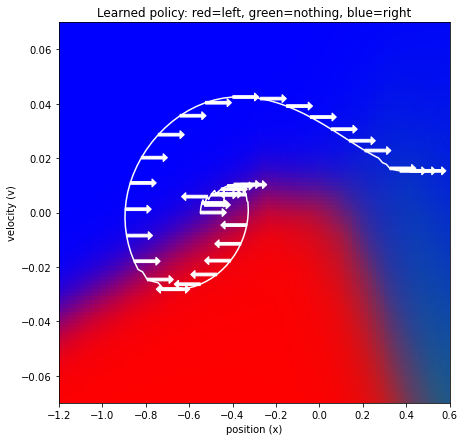

In [106]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    
    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(probs, extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed), aspect='auto')
    ax.set_title('Learned policy: red=left, green=nothing, blue=right')
    ax.set_xlabel('position (x)')
    ax.set_ylabel('velocity (v)')
    
    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color='white')
    
    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color='white', head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color='white', head_length=0.02)

with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, agent_simple)

### Bonus tasks

* __3 bonus__ (0.2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __4 bonus__ (0.4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * 0.4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.